In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
import re # This is for text processing

def clean_price(price_str):
    """Converts '1.63 Cr' or '82 Lac' into actual numbers"""
    if not isinstance(price_str, str): return 0
    clean_str = price_str.replace('₹', '').replace(',', '').strip()
    
    try:
        if 'Cr' in clean_str:
            number = float(re.findall(r"[\d\.]+", clean_str)[0])
            return int(number * 10000000)
        elif 'Lac' in clean_str:
            number = float(re.findall(r"[\d\.]+", clean_str)[0])
            return int(number * 100000)
        else:
            return 0
    except:
        return 0

# 1. Setup
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

url = "https://www.magicbricks.com/property-for-sale/residential-real-estate?bedroom=2,3&proptype=Multistorey-Apartment,Builder-Floor-Apartment,Penthouse,Studio-Apartment&cityName=Chennai"
driver.get(url)

data_list = []

try:
    wait = WebDriverWait(driver, 15)
    
    # Scroll logic
    last_height = driver.execute_script("return document.body.scrollHeight")
    for _ in range(1,100): 
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(3)
    
    # Locate elements
    price_elements = driver.find_elements(By.CLASS_NAME, "mb-srp__card__price--amount")
    title_elements = driver.find_elements(By.CLASS_NAME, "mb-srp__card--title")
    # We will try to find society name, but if it fails, we use the title
    soc_elements = driver.find_elements(By.CLASS_NAME, "mb-srp__card__society--name") 

    print(f"Found {len(price_elements)} properties.")

    for i in range(len(price_elements)):
        try:
            raw_price = price_elements[i].text
            title = title_elements[i].text if i < len(title_elements) else ""
            
            # LOGIC FIX: If society name is missing, extract location from Title
            # Example Title: "3 BHK Apartment for Sale in Koyambedu Chennai"
            if i < len(soc_elements) and soc_elements[i].text != "":
                location = soc_elements[i].text
            else:
                # Extract word between "in" and "Chennai"
                if " in " in title:
                    parts = title.split(" in ")
                    location = parts[1].replace("Chennai", "").strip()
                else:
                    location = "Chennai"

            # Clean the data instantly
            numeric_price = clean_price(raw_price)

            data_list.append({
                'Raw_Price': raw_price,
                'Numeric_Price': numeric_price, # Ready for analysis!
                'Title': title,
                'Location': location
            })
            
        except Exception as e:
            continue

except Exception as e:
    print(f"Error: {e}")

driver.quit()

# 2. Save with UTF-8-SIG (Fixes the weird symbols in Excel)
if data_list:
    df = pd.DataFrame(data_list)
    df.to_csv("chennai_real_estate_CLEAN.csv", index=False, encoding='utf-8-sig')
    print("SUCCESS! Saved clean data.")

Found 1500 properties.
SUCCESS! Saved clean data.


In [2]:
import pandas as pd

# Load your file
df = pd.read_csv("chennai_real_estate_CLEAN.CSV")

# The Regex "Magic"
# 1. 'in\s+'  -> Find the word "in" followed by whitespace
# 2. '(.*?)'  -> CAPTURE everything until...
# 3. '\s+Chennai' -> ...we hit " Chennai"
df['Actual Area'] = df['Title'].str.extract(r'in\s+(.*?)\s+Chennai')

# Check the specific T Nagar issue
print(df[df['Actual Area'].str.contains("T Nagar", na=False)])

       Raw_Price  Numeric_Price  \
18    ₹\n4.04 Cr       40400000   
182   ₹\n1.15 Cr       11500000   
230   ₹\n1.25 Cr       12500000   
313   ₹\n3.49 Cr       34900000   
378   ₹\n1.25 Cr       12500000   
456   ₹\n3.19 Cr       31900000   
533   ₹\n2.65 Cr       26500000   
970   ₹\n1.48 Cr       14800000   
1089  ₹\n1.15 Cr       11500000   
1350  ₹\n1.20 Cr       12000000   
1364  ₹\n1.50 Cr       15000000   
1415   ₹\n74 Lac        7400000   
1450     ₹\n2 Cr       20000000   
1472     ₹\n1 Cr       10000000   

                                                  Title  \
18               3 BHK Flat for Sale in T Nagar Chennai   
182         2 BHK Apartment for Sale in T Nagar Chennai   
230         2 BHK Apartment for Sale in T Nagar Chennai   
313         3 BHK Apartment for Sale in T Nagar Chennai   
378         2 BHK Apartment for Sale in T Nagar Chennai   
456         3 BHK Apartment for Sale in T Nagar Chennai   
533     3 BHK Builder Floor for Sale in T Nagar Chennai   
97

In [4]:
import pandas as pd
import re

# 1. Load your file (Make sure the name matches YOUR file exactly)
# If your file is a CSV, change this to pd.read_csv("filename.csv")
df = pd.read_csv("chennai_real_estate_CLEAN.csv")

# ---------------------------------------------------------
# STEP 1: Fix the "Location" Confusion
# ---------------------------------------------------------
# Rename the current 'Location' column to what it actually is: 'Society_Name'
df = df.rename(columns={'Location': 'Society_Name'})

# Extract the REAL location from the Title
# This grabs text between "in" and "Chennai"
df['Area_Locality'] = df['Title'].str.extract(r'in\s+(.*?)\s+Chennai')

# Trim extra spaces (fixes " T Nagar " -> "T Nagar")
df['Area_Locality'] = df['Area_Locality'].str.strip()

# ---------------------------------------------------------
# STEP 2: Fix the Price Confusion
# ---------------------------------------------------------
# If you already have 'Numeric_Price' with numbers like 26000000, we keep it.
# We will drop the text 'Raw_Price' column so it stops confusing you.
if 'Numeric_Price' in df.columns:
    df = df.drop(columns=['Raw_Price']) # Get rid of the messy text column

# ---------------------------------------------------------
# STEP 3: Organize the Columns
# ---------------------------------------------------------
# Let's reorder the columns to look professional
# We select only the columns we want, in the order we want
desired_columns = ['Area_Locality', 'Society_Name', 'Numeric_Price', 'Title']

# Create a new clean dataframe with just these columns
# (Use 'reindex' to avoid errors if a column is missing)
df_clean = df.reindex(columns=desired_columns)

# Drop rows where Area is still blank (NA)
df_clean = df_clean.dropna(subset=['Area_Locality'])

# ---------------------------------------------------------
# STEP 4: Save to a BRAND NEW file
# ---------------------------------------------------------
print("Saving final data...")
print(df_clean.head()) # Show preview in terminal
df_clean.to_csv("FINAL_REAL_ESTATE_DATA.csv", index=False)
print("Done! Open 'FINAL_REAL_ESTATE_DATA.csv' to see the result.")

Saving final data...
            Area_Locality                   Society_Name  Numeric_Price  \
0          Mogappair East  L and T Realty Avinya Enclave       26000000   
1          Valasaravakkam              Pragnya Eden Park       16700000   
2  Tambaram West Tambaram       Prestige Pallava Gardens        7130000   
3               Mogappair               Shriram 122 West       14000000   
4  Tambaram West Tambaram       Prestige Pallava Gardens       12200000   

                                               Title  
0      3 BHK Flat for Sale in Mogappair East Chennai  
1      3 BHK Flat for Sale in Valasaravakkam Chennai  
2  2 BHK Flat for Sale in Tambaram West Tambaram ...  
3           3 BHK Flat for Sale in Mogappair Chennai  
4  3 BHK Flat for Sale in Tambaram West Tambaram ...  
Done! Open 'FINAL_REAL_ESTATE_DATA.csv' to see the result.


In [5]:
import pandas as pd
import re

# 1. Load your consolidated file
df = pd.read_csv("FINAL_REAL_ESTATE_DATA.csv")
print(f"Original Row Count: {len(df)}")

# ---------------------------------------------------------
# STEP 1: Remove Duplicates
# ---------------------------------------------------------
# Real estate sites often list the same flat twice. 
# We remove rows where EVERYTHING (Price, Area, Title) is identical.
df = df.drop_duplicates()
print(f"Row Count after removing duplicates: {len(df)}")

# ---------------------------------------------------------
# STEP 2: Extract "BHK" from the Title
# ---------------------------------------------------------
# Your 'Title' column has valuable info like "3 BHK Flat...".
# Let's pull that number out into its own column.
# Regex Explanation: (\d+) means "find a number", \s*BHK means "followed by BHK"
df['BHK'] = df['Title'].str.extract(r'(\d+)\s*BHK')

# Convert it to a number (so you can do math later)
df['BHK'] = pd.to_numeric(df['BHK'], errors='coerce')

# ---------------------------------------------------------
# STEP 3: Standardize Text (The "Clean" Look)
# ---------------------------------------------------------
# Make everything Title Case (e.g., "anna nagar" -> "Anna Nagar")
# This ensures "chennai" and "Chennai" count as the same thing.
df['Area_Locality'] = df['Area_Locality'].str.title()
df['Society_Name'] = df['Society_Name'].str.title()

# ---------------------------------------------------------
# STEP 4: Remove "Impossible" Prices (Outliers)
# ---------------------------------------------------------
# Sometimes data has errors (e.g., a flat for ₹500).
# Let's keep only reasonable prices (e.g., > ₹10 Lakhs and < ₹50 Crores)
# Adjust these numbers based on what you see in your data!
df = df[(df['Numeric_Price'] > 1000000) & (df['Numeric_Price'] < 500000000)]

# ---------------------------------------------------------
# STEP 5: Save
# ---------------------------------------------------------
print(f"Final Clean Row Count: {len(df)}")
df.to_csv("FINAL_REAL_ESTATE_DATA_V2.csv", index=False)
print("Saved as 'FINAL_REAL_ESTATE_DATA_V2.csv'")

Original Row Count: 1457
Row Count after removing duplicates: 1422
Final Clean Row Count: 1421
Saved as 'FINAL_REAL_ESTATE_DATA_V2.csv'


Finding Metrics 

      Numeric_Price      BHK price_per_BHK
count       1421.00  1421.00       1421.00
mean    10495383.52     2.39    4253954.95
std      9688810.07     0.49    3511966.96
min      1400000.00     2.00     700000.00
25%      5250000.00     2.00    2400000.00
50%      7500000.00     2.00    3250000.00
75%     12000000.00     3.00    4750000.00
max    105000000.00     3.00   40000000.00
fig saved!


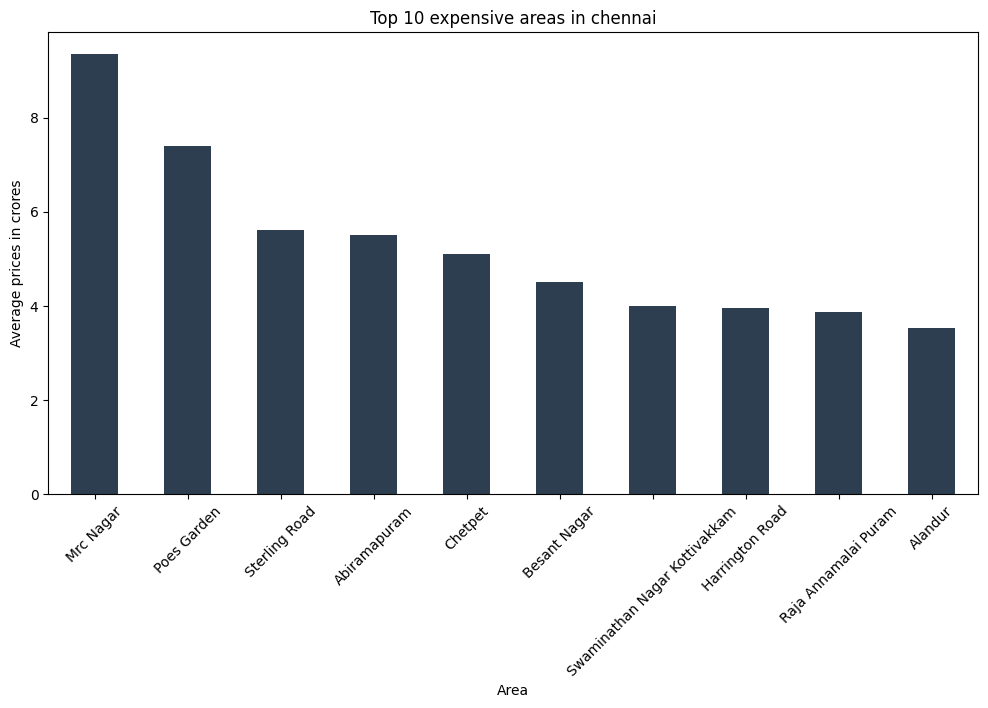

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("FINAL_REAL_ESTATE_DATA_V2.csv")

df['price_per_BHK'] = df['Numeric_Price'] / df['BHK']

def categorize_price(price):
    if price < 5000000:
         return 'budget'
    elif price < 15000000:
        return 'mid-range'
    else:
         return 'luxury'
df['price_segment'] = df['Numeric_Price'].apply(categorize_price)
df[['Numeric_Price','price_per_BHK','price_segment']].head()


print(df.describe().apply(lambda s: s.apply('{0:.2f}'.format)))


# Visualizing Metrics
top_locations = df.groupby('Area_Locality')['Numeric_Price'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
(top_locations/10000000).plot(kind ='bar',color = '#2c3e50')
plt.title('Top 10 expensive areas in chennai')
plt.ylabel('Average prices in crores')
plt.xlabel('Area')
plt.xticks(rotation=45)
plt.savefig('Top_Expensive_Areas.png',bbox_inches='tight')
print('fig saved!')







fig saved!


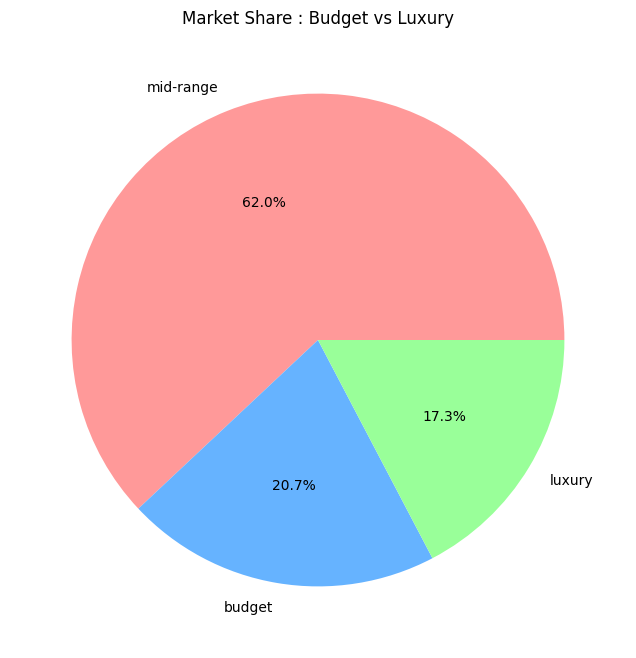

In [4]:
import matplotlib.pyplot as plt
segment_counts = df['price_segment'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(segment_counts,labels=segment_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Market Share : Budget vs Luxury')
plt.savefig('Price_Segments.png',bbox_inches = 'tight')
print('fig saved!')

fig saved!


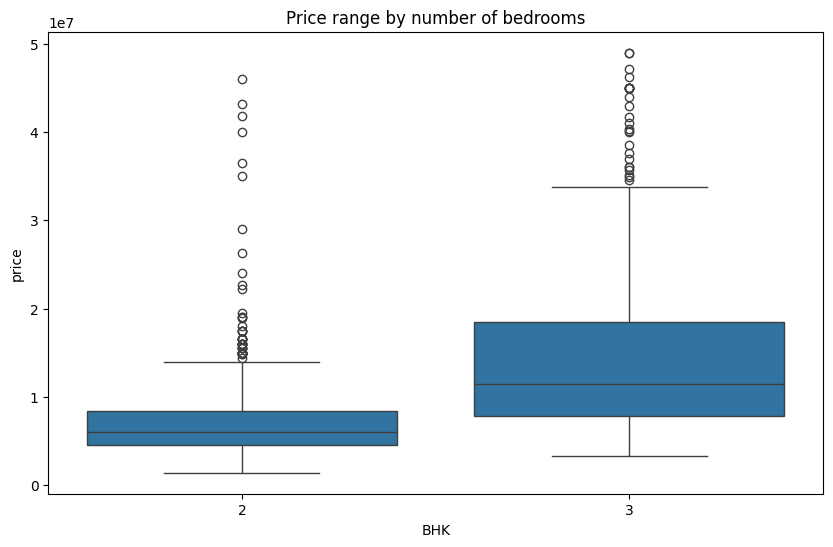

In [6]:
import matplotlib.pyplot as plt 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.boxplot(x='BHK',y='Numeric_Price', data=df[df['Numeric_Price']<50000000])
plt.title('Price range by number of bedrooms')
plt.ylabel('price')
plt.savefig('price by bhk.png')
print('fig saved!')

In [1]:
import pandas as pd 
df = pd.read_csv('FINAL_REAL_ESTATE_DATA_V2.csv')
df['Map_Location'] = df['Area_Locality'] + ",Chennai,Tamil Nadu,India"
df.to_csv("Chennai_Real_Estate_Power_BI_Ready.csv", index=False, encoding = 'utf-8-sig')
print("Success! Import 'Chennai_Real_Estate_Power_BI_Ready.csv' into Power BI")

Success! Import 'Chennai_Real_Estate_Power_BI_Ready.csv' into Power BI
